<a href="https://colab.research.google.com/github/jkworldchampion/tensorflow_model/blob/main/Vanilla_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Generating** **Dataset**

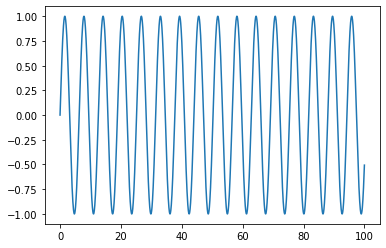

In [6]:
%matplotlib inline    

import numpy as np       
import matplotlib.pyplot as plt
import torch.optim as optim


# ====== Generating Dataset ====== #
num_data = 2400                         
t = np.linspace(0.0, 100.0, num_data)
y = np.sin(t)


# batch 생성
seq_len = 10                   # 10개 주고 다음 1개 예측
X = []
y_true = []
for i in range(len(t)-seq_len):
    X.append(y[i:i+seq_len])
    y_true.append(y[i+seq_len])
    

X = np.array(X)                # (2390, 10)
y_true = np.array(y_true)      # (2390,)


# [seq_len, batch_size, input_dim]
X = np.swapaxes(X,0,1)         # (10, 2390)  
X = np.expand_dims(X, axis=2)  # (10, 2390, 1)

plt.plot(t, y)

# **Model Define**

In [7]:
import torch
import torch.nn as nn


class RNN(nn.Module):
    def __init__(self, input_dim, output_dim, hid_dim, batch_size): 
        super(RNN, self).__init__()             #  super()를 사용해서 기반 클래스의 __init__ 메서드를 호출
        
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.hid_dim = hid_dim
        self.batch_size = batch_size
        
        self.u = nn.Linear(self.input_dim, self.hid_dim, bias=False)       # hidden_layer에 projection
        self.w = nn.Linear(self.hid_dim, self.hid_dim, bias=False) 
        self.v = nn.Linear(self.hid_dim, self.output_dim, bias=False)
        self.act = nn.Tanh()
        
        self.hidden = self.init_hidden()
        
    def init_hidden(self, batch_size=None):
        if batch_size is None:
            batch_size = self.batch_size
        return torch.zeros(batch_size, self.hid_dim)
    
    def forward(self, x):
        h = self.act(self.u(x) + self.w(self.hidden))
        y = self.v(h)
        return y, h

# **Train Trigonometric Function**

In [8]:
model = RNN(1, 1, 50, 2390)
loss_fn = nn.MSELoss()            # MSE 값을 구함
optimizer = optim.SGD(model.parameters(), lr=0.005)      
epoch = 100

for i in range(epoch):
    model.train()
    model.zero_grad()               # 역전파 전 gradients(기울기)를 초기화 해야함
    optimizer.zero_grad()            
    
    model.hidden = model.init_hidden()
    
    for x in X:
        x = torch.Tensor(x).float()
        y_true = torch.Tensor(y_true).float()

        y_pred, hidden = model(x)
        model.hidden = hidden

    loss = loss_fn(y_pred.view(-1), y_true.view(-1))
    loss.backward()
    optimizer.step()   
    # Optimzer는 update할 parameter와 learning rate 및 여러 다른 hyper-parameter를 받아 step() method 를 통해 업데이트한다.
    print(loss.item())

0.6476176381111145
0.5322489738464355
0.4370671808719635
0.3585743308067322
0.2939056158065796
0.2406957894563675
0.19698286056518555
0.16113348305225372
0.1317862868309021
0.10780613124370575
0.08824735134840012
0.07232320308685303
0.05938047915697098
0.04887809604406357
0.040368903428316116
0.03348439559340477
0.02792157605290413
0.023431997746229172
0.019812412559986115
0.016896933317184448
0.014550456777215004
0.012663185596466064
0.01114603504538536
0.009926869533956051
0.008947365917265415
0.00816043745726347
0.007528111804276705
0.007019820157438517
0.006610958371311426
0.006281760986894369
0.006016356870532036
0.005802012514322996
0.005628520622849464
0.005487698595970869
0.005372996907681227
0.005279174540191889
0.005202040076255798
0.005138237029314041
0.00508508738130331
0.005040448624640703
0.005002608988434076
0.004970202688127756
0.004942138679325581
0.004917545709758997
0.0048957280814647675
0.0048761311918497086
0.004858311731368303
0.00484191719442606
0.004826665390282

# **Predict Target Function**

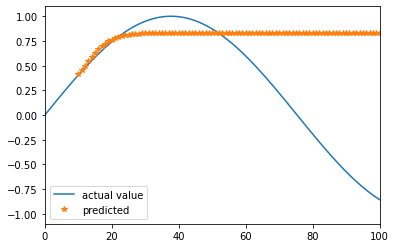

In [9]:
test_X = np.expand_dims(X[:, 0, :], 1)

list_y_pred = []

model.eval()
with torch.no_grad():
    model.hidden = model.init_hidden(batch_size=1)

    for x in test_X:
        x = torch.Tensor(x).float()
        y_pred, hidden = model(x)
        model.hidden = hidden
    list_y_pred.append(y_pred.view(-1).item())
    
    temp_X = list()
    temp_X += list(np.squeeze(test_X))[1:]
    temp_X.append(y_pred.view(-1).item())
    for i in range(num_data-seq_len-1):
        model.hidden = model.init_hidden(batch_size=1)
        
        temp2_X = torch.unsqueeze(torch.unsqueeze(torch.Tensor(temp_X), 1), 1)
        
        for x in temp2_X:
            y_pred, hidden = model(x)
            model.hidden = hidden
        list_y_pred.append(y_pred.view(-1).item())
        
        temp_X.append(y_pred.view(-1).item())
        temp_X.pop(0)

plt.plot(y, label='actual value')
plt.plot(list(range(10, 2400)), list_y_pred, '*', label='predicted')
plt.xlim(0, 100)
plt.legend()